# Evaluation of CyteType

CyteType is a tool for automatic curation of cell types in single cell, using an LLM Annotator Agent.

In this notebook, I try the tool on a few datasets and compare it with other annotation tools.

### Install Libraries

In [98]:
!python -m pip install -q cytetype scanpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dallo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [99]:
import anndata
import scanpy as sc
import cytetype
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize Paul15 dataset

The Paul et al 2015 dataset is a small single-cell dataset of myeloid cells, available from scanpy. The Cell types have been manually annotated, meaning we can compare cytetype's predictions against the true values.

In [100]:
#adata = sc.datasets.paul15()


In [101]:
import os
import scanpy as sc

if not os.path.exists("paul15_small.h5ad"):
    adata = sc.datasets.paul15()
    adata.write("paul15_small.h5ad")
else:
    adata = sc.read("paul15_small.h5ad")


### Process the data - compute clusters, etc

In [102]:
adata.obs["paul15_clusters"]

W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

In [103]:

# Load and preprocess your data
adata.var["gene_symbols"] = adata.var_names

# We compute the clusters as suggested by the tutorial
# However, this produces 10 clusters. We are going to use the 19 
# clusters from the original paper, which are stored in the `paul15_clusters` column.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata) 
sc.tl.rank_genes_groups(adata, groupby='paul15_clusters', method='t-test')

# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata, 
    group_key='paul15_clusters',                    # Required: cluster column name
    rank_key='rank_genes_groups',          # DE results key (default)
    gene_symbols_column='gene_symbols',    # Gene symbols column (default)
    n_top_genes=50,                        # Top marker genes per cluster
    results_prefix='cytetype'              # Prefix for result columns
)

Calculating expression percentages.
Extracting marker genes.
Data preparation completed. Ready for submitting jobs.


In [104]:
adata.obs

,paul15_clusters,leiden
W31105,7MEP,4
W31106,15Mo,5
W31107,3Ery,2
W31108,15Mo,3
W31109,3Ery,2
...,...,...
W39164,2Ery,0
W39165,13Baso,7
W39166,7MEP,4
W39167,15Mo,3


In [105]:
# How many clusters are there?
print(f"Number of clusters: {len(adata.obs['paul15_clusters'].unique())}")
adata.obs['paul15_clusters'].value_counts().sort_index()


Number of clusters: 19


paul15_clusters
1Ery        43
2Ery       329
3Ery       246
4Ery       124
5Ery       180
6Ery       173
7MEP       167
8Mk         68
9GMP        63
10GMP      153
11DC        30
12Baso      69
13Baso     300
14Mo       373
15Mo       186
16Neu      164
17Neu       22
18Eos        9
19Lymph     31
Name: count, dtype: int64

In [106]:
# Cluster annotation from original paper 
adata.obs


,paul15_clusters,leiden
W31105,7MEP,4
W31106,15Mo,5
W31107,3Ery,2
W31108,15Mo,3
W31109,3Ery,2
...,...,...
W39164,2Ery,0
W39165,13Baso,7
W39166,7MEP,4
W39167,15Mo,3


### Call the Agent! Run the annotation

In [107]:
# Run annotation
adata = annotator.run(
    study_context="Mouse bone marrow cells undergoing myeloid differentiation"
)

# View results
#print(adata.obs.cytetype_leiden)

Waiting for results for job ID: 0d55c475-0ed5-486f-ae8f-8e4c79a8bcb3
View the automatically updating visualization report at: https://nygen-labs-prod--cell-annotation-agent-fastapi-app.modal.run/report/0d55c475-0ed5-486f-ae8f-8e4c79a8bcb3
250604:1023:33 |INFO| [STARTING WORKFLOWS]: Job ID: 0d55c475-0ed5-486f-ae8f-8e4c79a8bcb3
250604:1023:33 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250604:1023:49 |INFO| [WORKFLOW STEP 2/3]: Running cluster contextualization, annotation, review, and ontology assignment
250604:1023:52 |INFO| [Cluster: 1] Generating cluster-specific context...
250604:1023:54 |INFO| [Cluster: 10] Generating cluster-specific context...
250604:1023:58 |INFO| [Cluster: 11] Generating cluster-specific context...
250604:1024:00 |INFO| [Cluster: 12] Generating cluster-specific context...
250604:1024:02 |INFO| [Cluster: 13] Generating cluster-specific context...
250604:1024:11 |INFO| [Cluster: 1] Annotating cluster...
250604:1024:12 |INFO| [Cluster: 12] Annotating cl

### Compare annotation with existing one

The original annotation are more granular than the ones from Cytetype, so we manually create a dictionary to make a comparison.

In [108]:
print(adata.obs.cytetype_paul15_clusters.unique().to_list())

['Myeloid progenitor cell', 'Promyelocyte', '', 'Erythroid progenitor', 'Myeloid Progenitor', 'Neutrophil', 'Megakaryocyte', 'Common myeloid progenitor', 'Myeloid progenitor', 'Erythroid cell', 'Natural Killer Cell', 'Hematopoietic progenitor cell', 'Dendritic cell']


C:\Users\dallo\AppData\Local\Temp\ipykernel_36588\2244391105.py:1: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  print(adata.obs.cytetype_paul15_clusters.unique().to_list())


In [109]:
print(adata.obs.paul15_clusters.unique().to_list())

['7MEP', '15Mo', '3Ery', '4Ery', '2Ery', '17Neu', '14Mo', '13Baso', '8Mk', '9GMP', '10GMP', '16Neu', '5Ery', '1Ery', '6Ery', '19Lymph', '12Baso', '18Eos', '11DC']


C:\Users\dallo\AppData\Local\Temp\ipykernel_36588\398411659.py:1: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  print(adata.obs.paul15_clusters.unique().to_list())


In [110]:
label_map = {
    '1Ery': 'Erythroblast',
    '2Ery': 'Erythroid precursor',
    '3Ery': 'Erythroblast',
    '4Ery': 'Erythroid precursor',
    '5Ery': 'Erythroid cell',
    '6Ery': 'Erythroid progenitor',
    
    '7MEP': 'Myeloid progenitor cell',
    '8Mk': 'Megakaryocyte',
    '9GMP': 'Hematopoietic progenitor cell',
    '10GMP': 'Hematopoietic progenitor cell',
    
    '11DC': 'Antigen-presenting myeloid cell',
    '12Baso': 'Mast cell',
    '13Baso': 'Mast cell',
    
    '14Mo': 'Neutrophil promyelocyte',
    '15Mo': 'Neutrophil promyelocyte',
    
    '16Neu': 'Neutrophil',
    '17Neu': 'Neutrophil',
    
    '18Eos': 'Eosinophil',
    '19Lymph': 'Natural Killer (NK) cell'
}


In [111]:
adata.obs

,paul15_clusters,leiden,cytetype_paul15_clusters
W31105,7MEP,4,Myeloid progenitor cell
W31106,15Mo,5,Promyelocyte
W31107,3Ery,2,
W31108,15Mo,3,Promyelocyte
W31109,3Ery,2,
...,...,...,...
W39164,2Ery,0,
W39165,13Baso,7,
W39166,7MEP,4,Myeloid progenitor cell
W39167,15Mo,3,Promyelocyte


In [112]:
adata.obs["true_broad"] = adata.obs["paul15_clusters"].map(label_map)

conf_mat = pd.crosstab(adata.obs["true_broad"], adata.obs["cytetype_paul15_clusters"], normalize='index')
conf_mat

cytetype_paul15_clusters,,Common myeloid progenitor,Dendritic cell,Erythroid cell,Erythroid progenitor,Hematopoietic progenitor cell,Megakaryocyte,Myeloid Progenitor,Myeloid progenitor,Myeloid progenitor cell,Natural Killer Cell,Neutrophil,Promyelocyte
true_broad,,,,,,,,,,,,,
Antigen-presenting myeloid cell,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Eosinophil,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Erythroblast,0.851211,0.000000,0.0,0.148789,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Erythroid cell,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Erythroid precursor,0.726269,0.000000,0.0,0.000000,0.273731,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Erythroid progenitor,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Hematopoietic progenitor cell,0.000000,0.291667,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.708333,0.0,0.0,0.000000,0.000000
Mast cell,0.813008,0.000000,0.0,0.000000,0.000000,0.186992,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
Megakaryocyte,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000


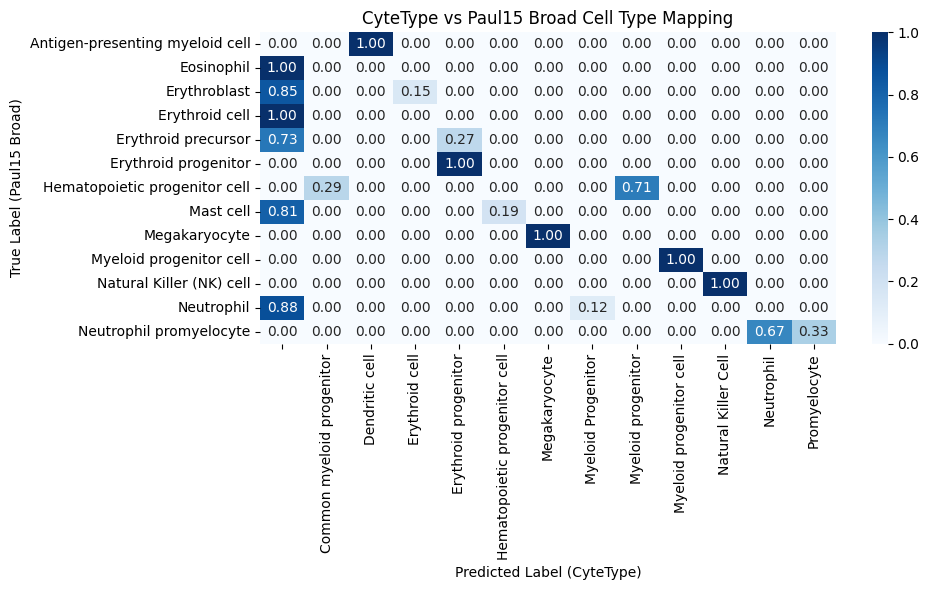

In [113]:
# Plot Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()

## Repeating the confusion matrix, using the original labels


In the code above we had to manually match the Paul 15 labels with the ones generated by cytetype. Here we use the original lables, although we expand them to make it more readable, and we keep the original values.


In [126]:
import pandas as pd

# Step 1: Mapping from cluster ID to full name
paul15_label_fullname = {
    '1Ery': '1Ery - Early erythroid progenitors',
    '2Ery': '2Ery - Intermediate erythroid stage',
    '3Ery': '3Ery - Late erythroid / erythroblast',
    '4Ery': '4Ery - Terminally differentiating erythrocytes',
    '5MEP': '5MEP - Megakaryocyte-Erythroid Progenitor',
    '6MEP': '6MEP - Megakaryocyte-Erythroid Progenitor (more mature)',
    '7MEP': '7MEP - Megakaryocyte-Erythroid Progenitor (late stage)',
    '8GMP': '8GMP Granulocyte–monocyte progenitor',
    '9DC':  '9DC - Dendritic cell progenitors',
    '10Baso': '10Baso - Basophil progenitors',
    '11Mo': '11Mo - Monocyte progenitors',
    '12Mo': '12Mo - Differentiated monocyte progenitors',
    '13Baso': '13Baso - Mature basophil progenitors',
    '14Mo': '14Mo - Late-stage monocytes',
    '15Mo': '15Mo - Mature monocytes',
    '16Neu': '16Neu - Neutrophil progenitors',
    '17Neu': '17Neu - Late-stage neutrophils',
    '18Eos': '18Eos - Eosinophil progenitors',
    '19Lymph': '19Lymph - Lymphoid-like cells (NK/T precursors or contaminants)',
}

# Step 2: Map full names into obs
adata.obs["paul15_fullname"] = adata.obs["paul15_clusters"].map(paul15_label_fullname)
adata.obs.head()


,paul15_clusters,leiden,cytetype_paul15_clusters,true_broad,paul15_fullname
W31105,7MEP,4,Myeloid progenitor cell,Myeloid progenitor cell,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W31106,15Mo,5,Promyelocyte,Neutrophil promyelocyte,15Mo - Mature monocytes
W31107,3Ery,2,,Erythroblast,3Ery - Late erythroid / erythroblast
W31108,15Mo,3,Promyelocyte,Neutrophil promyelocyte,15Mo - Mature monocytes
W31109,3Ery,2,,Erythroblast,3Ery - Late erythroid / erythroblast


In [137]:

# Step 3: Define full-name order
manual_order_full = list(paul15_label_fullname.values())


# Step 4: Create and reorder confusion matrix
conf_mat_full = pd.crosstab(
    adata.obs["paul15_fullname"],
    adata.obs["cytetype_paul15_clusters"],
    normalize='index'
)
# Only keep labels that exist in the confusion matrix
existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# Reorder based on existing labels only
conf_mat_ordered = conf_mat_full.loc[existing_labels]

# Optional: reorder columns if matching set
if all(label in conf_mat_ordered.columns for label in manual_order_full):
    conf_mat_ordered = conf_mat_ordered[manual_order_full]

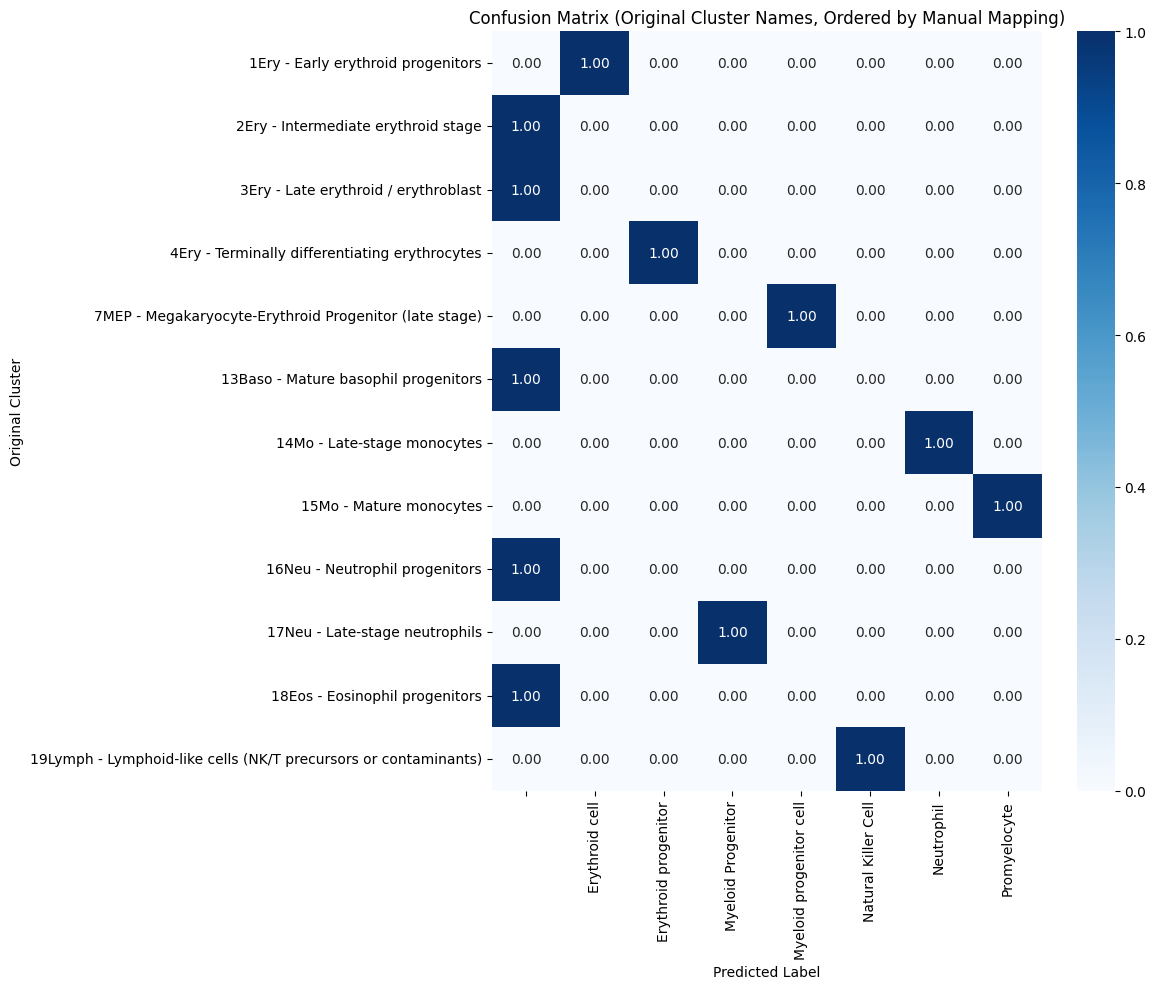

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping)")
plt.xlabel("Predicted Label")
plt.ylabel("Original Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## What if we give the wrong description?

Let's give a wrong instruction to CyteType, for example by saying that this is a retina dataset in Zebrafish, to see if it still returns good results

In [117]:
adata2 = adata.copy()
# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata2, 
    group_key='paul15_clusters',                    # Required: cluster column name
    rank_key='rank_genes_groups',          # DE results key (default)
    gene_symbols_column='gene_symbols',    # Gene symbols column (default)
    n_top_genes=50,                        # Top marker genes per cluster
    results_prefix='cytetype'              # Prefix for result columns
)

Calculating expression percentages.
Extracting marker genes.
Data preparation completed. Ready for submitting jobs.


In [118]:
adata2 = annotator.run(
    study_context="Zebrafish retina development during embryogenesis"
)


Waiting for results for job ID: b70c7a66-2f38-4499-bb6c-9987f91dabc6
View the automatically updating visualization report at: https://nygen-labs-prod--cell-annotation-agent-fastapi-app.modal.run/report/b70c7a66-2f38-4499-bb6c-9987f91dabc6
250604:1105:38 |INFO| [STARTING WORKFLOWS]: Job ID: b70c7a66-2f38-4499-bb6c-9987f91dabc6
250604:1105:38 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250604:1105:55 |INFO| [WORKFLOW STEP 2/3]: Running cluster contextualization, annotation, review, and ontology assignment
250604:1106:01 |INFO| [Cluster: 1] Generating cluster-specific context...
250604:1106:05 |INFO| [Cluster: 10] Generating cluster-specific context...
250604:1106:10 |INFO| [Cluster: 11] Generating cluster-specific context...
250604:1106:15 |INFO| [Cluster: 12] Generating cluster-specific context...
250604:1106:19 |INFO| [Cluster: 13] Generating cluster-specific context...
250604:1106:25 |INFO| [Cluster: 11] Annotating cluster...
250604:1106:27 |INFO| [Cluster: 1] Annotating cl

In [139]:
adata2.obs["true_broad"] = adata2.obs["paul15_clusters"].map(label_map)

pd.crosstab(adata2.obs["true_broad"], adata2.obs["cytetype_paul15_clusters"], normalize='index')


cytetype_paul15_clusters,,Endothelial cell,Eosinophil,Erythrocyte,Erythrocyte (Red Blood Cell),Erythroid cell,Microglia,Myeloid cell,Müller glia,NK cell,Neutrophil,Neutrophil (blood contamination),Retinal progenitor cell
true_broad,,,,,,,,,,,,,
Antigen-presenting myeloid cell,1.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Eosinophil,0.00000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Erythroblast,0.00000,0.0,0.0,0.148789,0.000000,0.851211,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Erythroid cell,0.00000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Erythroid precursor,0.00000,0.0,0.0,0.726269,0.273731,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Erythroid progenitor,0.00000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Hematopoietic progenitor cell,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.291667,0.000000,0.0,0.0,0.000000,0.00000,0.708333
Mast cell,0.00000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
Megakaryocyte,0.00000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000


In [141]:
adata2.obs["paul15_fullname"] = adata2.obs["paul15_clusters"].map(paul15_label_fullname)


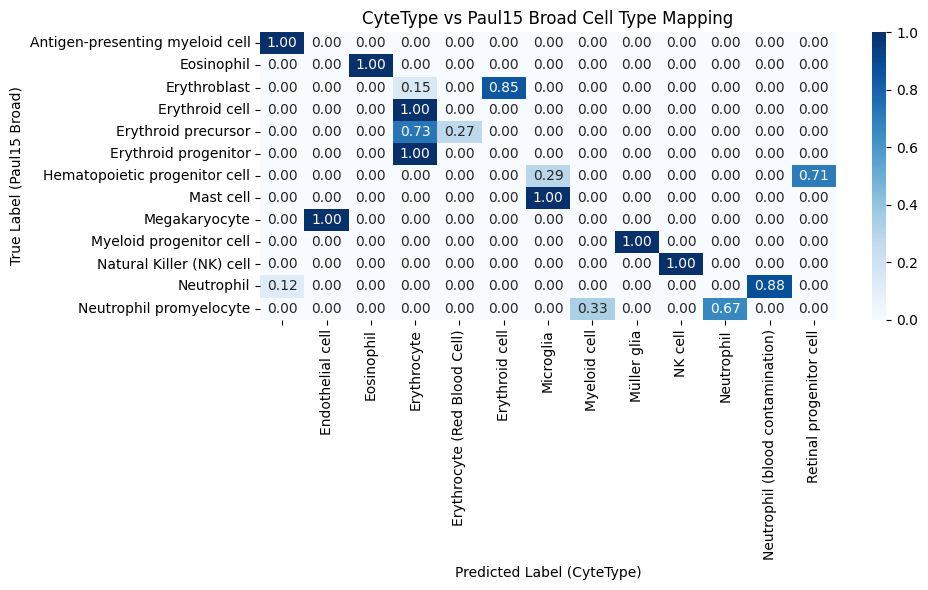

In [140]:
# Create normalized confusion matrix
conf_mat = pd.crosstab(
    adata2.obs["true_broad"], 
    adata2.obs["cytetype_paul15_clusters"], 
    normalize='index'
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()

In [142]:
# Let's also look at the Confusion matrix with the original cluster names
conf_mat_original = pd.crosstab(adata2.obs["paul15_clusters"], adata2.obs["cytetype_paul15_clusters"], normalize='index')
conf_mat_original



# Step 3: Define full-name order
manual_order_full = list(paul15_label_fullname.values())


# Step 4: Create and reorder confusion matrix
conf_mat_full = pd.crosstab(
    adata2.obs["paul15_fullname"],
    adata2.obs["cytetype_paul15_clusters"],
    normalize='index'
)
# Only keep labels that exist in the confusion matrix
existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# Reorder based on existing labels only
conf_mat_ordered = conf_mat_full.loc[existing_labels]

# Optional: reorder columns if matching set
if all(label in conf_mat_ordered.columns for label in manual_order_full):
    conf_mat_ordered = conf_mat_ordered[manual_order_full]

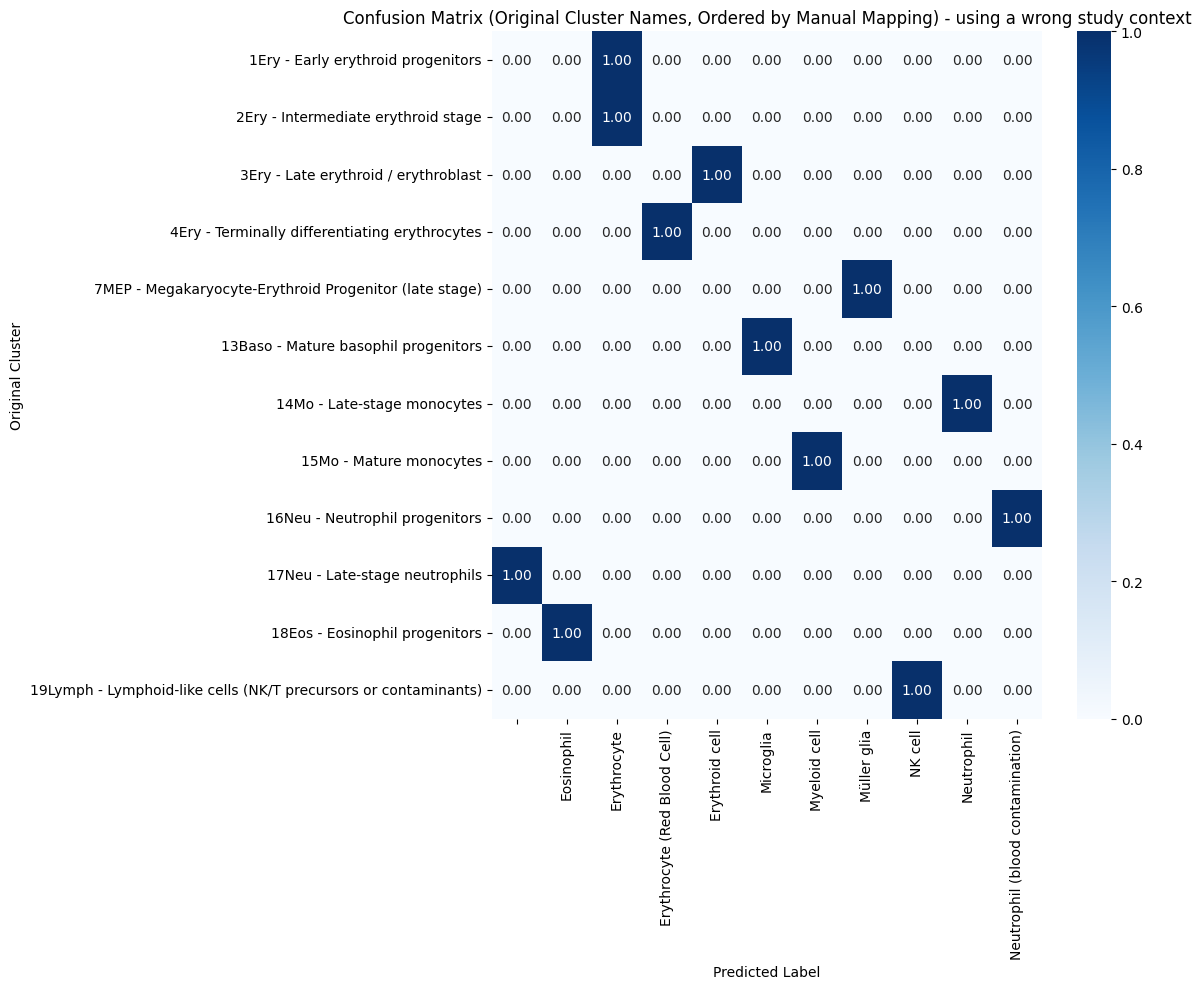

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping) - using a wrong study context")
plt.xlabel("Predicted Label")
plt.ylabel("Original Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
